# 07 Full model: Extreme Gradient Boosting with TFIDF + complexity features

Go to last cell for full model

In [128]:
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

from scipy.sparse import hstack, csr_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

In [2]:
df = pd.read_csv('../data/spanish_corpus_features_v2.csv')

In [3]:
df.head()

,headline,text,n_sentences_text,n_words_text,avg_words_sent_text,avg_word_size_text,ttr_text,n_words_headline,avg_word_size_headline,ttr_headline,label
0,sofía castro y alejandro peña pretelini: una i...,sofía castro y alejandro peña pretelini: una i...,5,123,24.600000,6.398374,69.105691,8,7.500000,100.0,1
1,un paso más cerca de hacer los exámenes 'online',un paso más cerca de hacer los exámenes 'onlin...,8,224,28.000000,7.205357,77.232143,5,5.800000,100.0,1
2,esto es lo que los científicos realmente piens...,esto es lo que los científicos realmente piens...,29,467,16.103448,7.573876,64.668094,4,9.500000,100.0,1
3,inicia impresión de boletas para elección pres...,inicia impresión de boletas para elección pres...,10,167,16.700000,7.964072,63.473054,5,8.400000,100.0,1
4,a *number* día del mundial,a *number* día del mundial\nfifa.com sigue la ...,4,57,14.250000,7.368421,84.210526,3,5.333333,100.0,1


In [4]:
df.shape

(971, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 11 columns):
headline                  971 non-null object
text                      971 non-null object
n_sentences_text          971 non-null int64
n_words_text              971 non-null int64
avg_words_sent_text       971 non-null float64
avg_word_size_text        971 non-null float64
ttr_text                  971 non-null float64
n_words_headline          971 non-null int64
avg_word_size_headline    971 non-null float64
ttr_headline              971 non-null float64
label                     971 non-null int64
dtypes: float64(5), int64(4), object(2)
memory usage: 83.6+ KB


In [6]:
df.columns

Index(['headline', 'text', 'n_sentences_text', 'n_words_text',
       'avg_words_sent_text', 'avg_word_size_text', 'ttr_text',
       'n_words_headline', 'avg_word_size_headline', 'ttr_headline', 'label'],
      dtype='object')

In [7]:
y = df['label']

## Spanish tokenization

    - Spanish stopwords
    - Added more spanish punctuation
    - Created stems with lemmas, using the rooting word

In [8]:
# stopword list to use
spanish_stopwords = stopwords.words('spanish')

# spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

# punctuation to remove
non_words = list(punctuation)

# adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    # remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    # tokenization
    tokens =  word_tokenize(text)

    # stemming
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TFIDF Vectorizer transformation with the tokenization explaned

In [9]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

tfvocab = tfidf_vectorizer.get_feature_names()

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## Make Dense dataframe Sparse, and Combine with TF-IDF features

In [10]:
numerical_features = ['n_sentences_text', 'n_words_text', 'avg_words_sent_text',
       'avg_word_size_text', 'ttr_text', 'n_words_headline','avg_word_size_headline']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
# X = df[numerical_features]
tfvocab = df[numerical_features].columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(tfvocab))

971 Rows and 15612 Cols
Feature Names Length:  15612


In [11]:
# Calculating level of imbalance for future models.
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]
print("Imbalance Weight: ", imbalance_weight)

Imbalance Weight:  0.9775967413441956


### Split into testing set, training set and validation set

In [34]:
# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

# XGBoost Classifier grid_search

In [49]:
xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', silent = True, nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'learning_rate': [0.1, 0.01],
              'n_estimators': [1000, 1500, 2000, 2500],
              'max_depth': [3, 6, 9], 
              'subsample': [0.4, 0.6, 0.8], 
              'colsample_bytree': [0.5, 0.75, 1],
              'min_child_weight' : [1, 5, 10],
              'lambda': [1, 1.5],
              'alpha': [0, 0.4, 0.6]}

In [51]:
folds = 3

skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 43)

grid_search = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, 
                                   scoring='roc_auc', n_jobs = 4, cv = skf.split(X_train, y_train), verbose = 3)

In [52]:
%%time

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   40.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 26.4min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed: 39.0min
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed: 54.8min
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed: 78.5min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 105.3min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 135.7min
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed: 170.5min
[Parallel(n_jobs=4)]: Done 4600 tasks      | elapsed: 195.7min
[Parallel(n_jobs=4)]: Done 5400 tasks      | elapsed: 224.5min
[Parallel(n_jobs=4)]: Done 6264 tasks      | elapsed: 266.2min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 31

[01:20:11] WARNING: /tmp/pip-build-ocghergh/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 57 s, sys: 5.8 s, total: 1min 2s
Wall time: 8h 44min 31s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fcffdb22ba0>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=...
                                     seed=43, silent=True, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=4,
             param_grid={'alpha': [0, 0.4, 0.6],
                         'colsample_b

In [56]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
best_estimator = grid_search.best_estimator_

print('\n Best score:')
print(grid_search.best_score_ * 2 - 1)

print('\n Best parameters:')
print(grid_search.best_params_)


 Best estimator:
XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1, learning_rate=0.01,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.9775967413441956, seed=43, silent=True,
              subsample=0.6, tree_method='exact', ...)

 Best score:
0.7776910817874672

 Best parameters:
{'alpha': 0, 'colsample_bytree': 0.75, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.6}


## XGBoost - eXtreme Gradient Boosting

In [115]:
xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'alpha': 0, 
              'colsample_bytree': 0.75, 
              'lambda': 1, 
              'learning_rate': 0.01,
              'max_depth': 3, 
              'min_child_weight': 1, 
              'n_estimators': 1000, 
              'subsample': 0.6}

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=0.9775967413441956, seed=43, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Predictions & results

Testing AUC: 0.889859


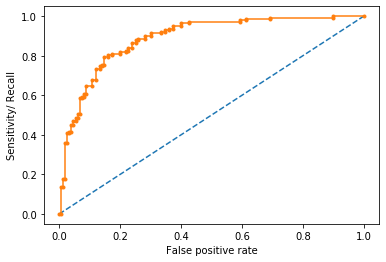

Logloss: 6.51
Accuracy: 81.16


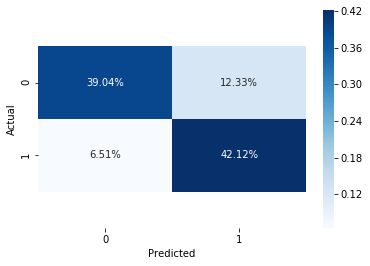

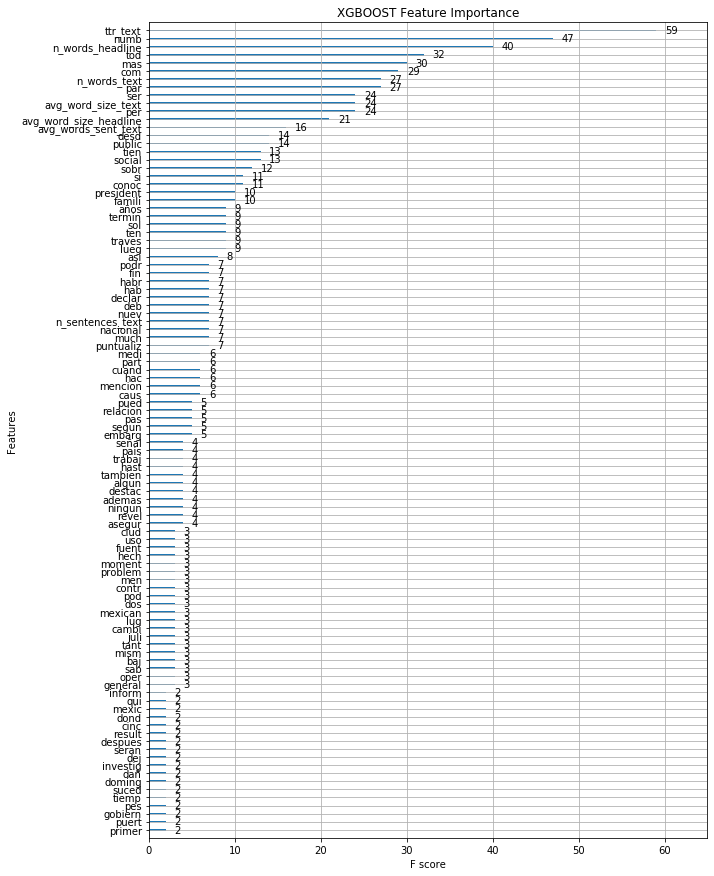

In [135]:
########### Predictions and results ###########

# predictions
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

# testing AUC
auc = roc_auc_score(y_test, probs)
print('Testing AUC: %f' % auc)

# roc curve calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

# plot the limits for no skill
plt.plot([0, 1], [0, 1], linestyle = '--')

# plot the roc curve

plt.plot(false_positive_rate, true_positive_rate, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show();

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (xgb_model.score(X_test, y_test) * 100))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, fmt = '.2%', cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

########### Feature importance ###########

dict_features = dict(enumerate(tfvocab))

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 15])
axsub = xgb.plot_importance(xgb_model, max_num_features = 100, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(tfvocab))
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

# feature importance
plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(lst_yticklabels)
plt.show()

# Full model

/home/pipe11/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['algun', 'com', 'contr', 'cuand', 'desd', 'dond', 'durant', 'eram', 'estab', 'estais', 'estam', 'estan', 'estand', 'estaran', 'estaras', 'esteis', 'estem', 'esten', 'estes', 'estuv', 'fuer', 'fues', 'fuim', 'fuist', 'hab', 'habr', 'habran', 'habras', 'hast', 'hem', 'hub', 'mas', 'mia', 'mias', 'mio', 'mios', 'much', 'nad', 'nosotr', 'nuestr', 'par', 'per', 'poc', 'porqu', 'qui', 'seais', 'seam', 'sent', 'ser', 'seran', 'seras', 'si', 'sient', 'sint', 'sobr', 'som', 'suy', 'tambien', 'tant', 'ten', 'tendr', 'tendran', 'tendras', 'teng', 'tien', 'tod', 'tuv', 'tuy', 'vosotr', 'vuestr'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Testing AUC: 0.889859


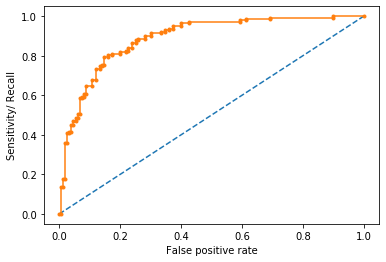

Logloss: 6.51
Accuracy: 81.16


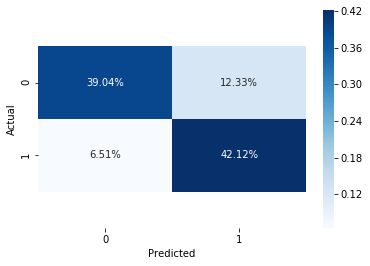

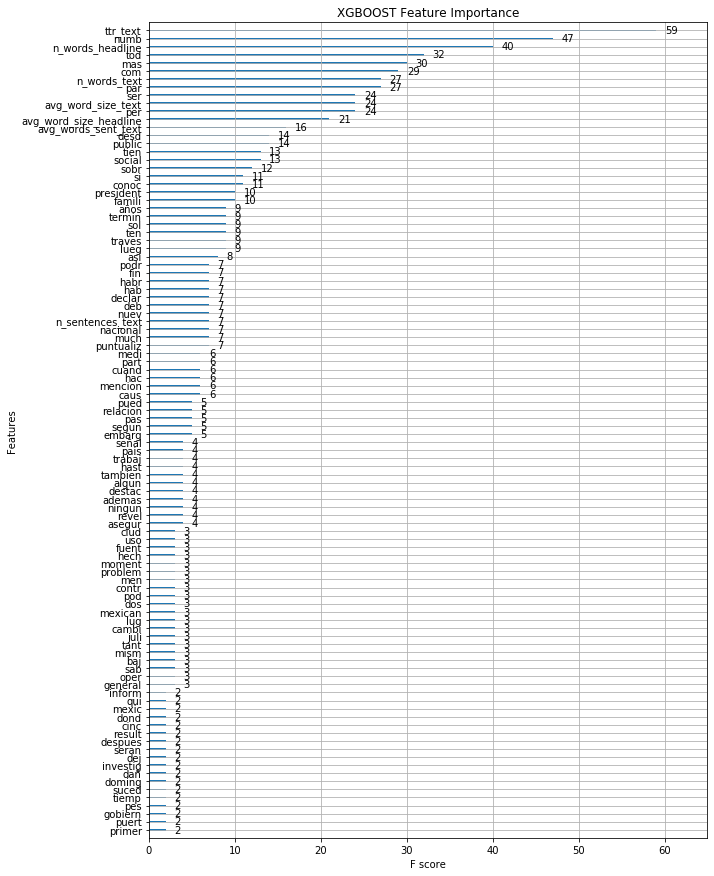

In [22]:
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

from scipy import stats
from scipy.sparse import hstack, csr_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, classification_report, log_loss

df = pd.read_csv('../data/spanish_corpus_features_v2.csv')
y = df['label']

####### TFIDF Transformation to text ########

#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems


tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

tfvocab = tfidf_vectorizer.get_feature_names()


########### Combine features & train, test split ########### 

numerical_features = ['n_sentences_text', 'n_words_text', 'avg_words_sent_text',
       'avg_word_size_text', 'ttr_text', 'n_words_headline','avg_word_size_headline']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
tfvocab = df[numerical_features].columns.tolist() + tfvocab

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'alpha': 0, 
              'colsample_bytree': 0.75, 
              'lambda': 1, 
              'learning_rate': 0.01,
              'max_depth': 3, 
              'min_child_weight': 1, 
              'n_estimators': 1000, 
              'subsample': 0.6}

xgb_model.fit(X_train, y_train)


########### Predictions and results ###########

# predictions
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

# testing AUC
auc = roc_auc_score(y_test, probs)
print('Testing AUC: %f' % auc)

# roc curve calculation
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, probs)

# plot the limits for no skill
plt.plot([0, 1], [0, 1], linestyle = '--')

# plot the roc curve

plt.plot(false_positive_rate, true_positive_rate, marker = '.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
plt.show();

# accuracy score
print('Logloss: %.2f' % (log_loss(y_test, y_pred)))
print('Accuracy: %.2f' % (xgb_model.score(X_test, y_test) * 100))

# confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred, labels = [0, 1])
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot = True, fmt = '.2%', cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();


########### Feature importance ###########

dict_features = dict(enumerate(tfvocab))

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 15])
axsub = xgb.plot_importance(xgb_model, max_num_features = 100, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(tfvocab))
lst_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [dict_features[int(i)] for i in lst_yticklabels]

# feature importance
plt.title("XGBOOST Feature Importance")
axsub.set_yticklabels(lst_yticklabels)
plt.show()